# **Import Needed Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
from skimage import io
from skimage.transform import  resize
from skimage.color import rgb2gray
from google.colab import autoviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve, auc, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

# **1.1_ Please upload the targz file**

In [18]:
from google.colab import files
uploaded = files.upload()


Saving EnglishImg.tgz to EnglishImg.tgz


## **Extract just the 4 needed folders**

In [2]:
# Path to the .tgz file
tgz_file_path = '/content/EnglishImg.tgz'

# List of subdirectories to extract
subdirectories_to_extract = [
    'English/Img/GoodImg/Bmp/Sample005/',
    'English/Img/GoodImg/Bmp/Sample011/',
    'English/Img/GoodImg/Bmp/Sample057/',
    'English/Img/GoodImg/Bmp/Sample018/'
]

# Destination path for extraction
destination_path = '/content/'

with tarfile.open(tgz_file_path, 'r:gz') as tar:
    # List all members in the archive
    members = tar.getmembers()

    # Iterate through the members and extract only the specified subdirectories
    for member in members:
        for subdirectory in subdirectories_to_extract:
            if member.name.startswith(subdirectory):
                tar.extract(member, path=destination_path)


### Read the images from the 4 subdirectories
### label each images into its corresponding letters
### convert every image into gray scale and resize ti 28 * 28 pixels
### Create a dataframe to the whole images and save it for further need

In [3]:
parent_directory = '/content/English/Img/GoodImg/Bmp'

subdirectories = ['Sample005', 'Sample011', 'Sample057', 'Sample018']

images = []
labels = []
image_filenames = []

for label, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(parent_directory, subdir)

    image_files = [f for f in os.listdir(subdir_path) if f.endswith('.png')]

    for image_file in image_files:
        image_path = os.path.join(subdir_path, image_file)

        image = io.imread(image_path)
        image = rgb2gray(image)

        images.append(image)
        labels.append(label)
        image_filenames.append(image_file)

images = np.array(images)
images = [resize(img, (28, 28)) for img in images]
label_mapping = {
    0: '4',
    1: 'A',
    2: 'U',
    3: 'H'
}

labels = [label_mapping[label] for label in labels]
data = pd.DataFrame({'Image': images, 'Label': labels, 'Image Filename': image_filenames})


In [4]:
data

,Image,Label,Image Filename
0,"[[0.6069828920794778, 0.6087645287917142, 0.60...",4,img005-00022.png
1,"[[0.8392273039215685, 0.8392878921568627, 0.83...",4,img005-00019.png
2,"[[0.2300562832635245, 0.2227196269514614, 0.21...",4,img005-00032.png
3,"[[0.25113659695695023, 0.25048025450945155, 0....",4,img005-00002.png
4,"[[0.7131766902759937, 0.7130395433046856, 0.71...",4,img005-00034.png
...,...,...,...
834,"[[0.3111028777056426, 0.3055762374111114, 0.31...",H,img018-00183.png
835,"[[0.7060452627035774, 0.692703164148221, 0.699...",H,img018-00189.png
836,"[[0.4013924086306933, 0.4047186299374385, 0.39...",H,img018-00122.png
837,"[[0.15155651348479954, 0.16337707113899935, 0....",H,img018-00037.png


### Function to show the histogram for the images labels

In [5]:
def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

### Function to display the confusion matrix as a heatmap

In [6]:
def binary_confusion_mx(y_test, y_pred, label):
    cm = confusion_matrix(y_test, y_pred)
    class_labels = ['A', '4']  # You can customize these labels if needed

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix {label}', size=10)
    plt.show()

In [7]:
def confusion_mx(y_test, y_pred, class_labels , label):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix {label}',size= 10)
    plt.show()

### Function to display the accuracy, precision, recall from the confusion matrix manually

In [8]:
def metrics(true , pred):
    cm = confusion_matrix(true , pred)
    tn = cm[0][0]
    tp = cm[1][1]
    fp = cm[1][0]
    fn = cm[0][1]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return accuracy, precision, recall

In [9]:
class_labels = ["A", "4", "U", "H"]
def class_metrics(y_true, y_pred, class_label):
    class_idx = class_labels.index(class_label)
    TP = np.sum((y_true == class_idx) & (y_pred == class_idx))
    TN = np.sum((y_true != class_idx) & (y_pred != class_idx))
    FP = np.sum((y_true != class_idx) & (y_pred == class_idx))
    FN = np.sum((y_true == class_idx) & (y_pred != class_idx))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1


In [10]:
def cm_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm).sum()
    all_samples = cm.sum()

    accuracy = tp / all_samples

    return accuracy

### Display the histogram for the images labels

In [11]:
chart = categorical_histogram(data, *['Label'], **{})
chart

In [12]:
data["Label"].value_counts()

A    558
H    193
4     47
U     41
Name: Label, dtype: int64

### Display a random images from each class in gray scale

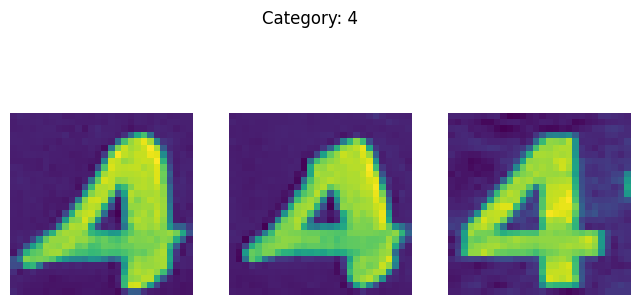

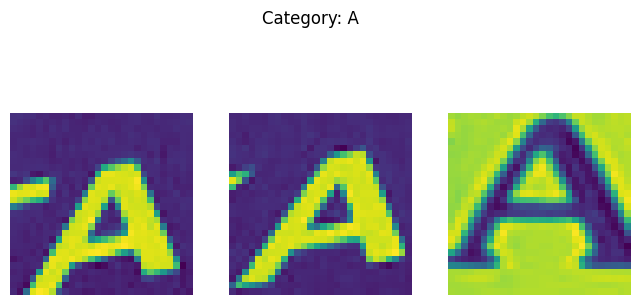

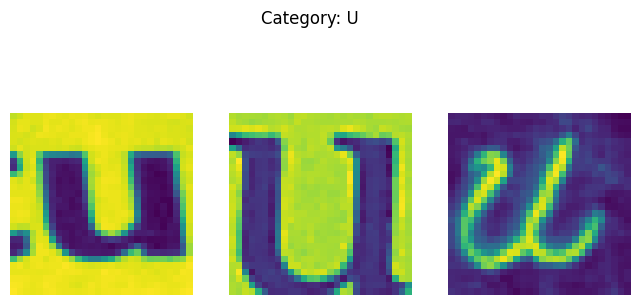

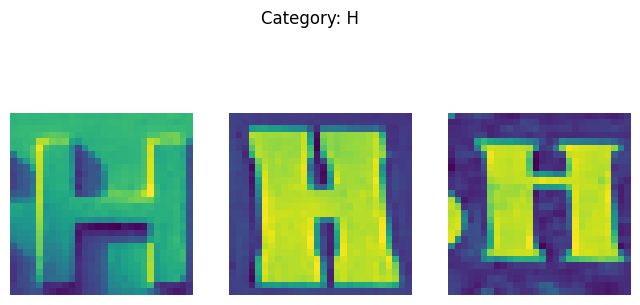

In [13]:
unique_labels = data['Label'].unique()
np.random.seed(42)

for label in unique_labels:
    subset = data[data['Label'] == label]

    random_indices = np.random.choice(subset.index, 3, replace=False)
    plt.figure(figsize=(8, 4))
    plt.suptitle(f'Category: {label}')

    for i, index in enumerate(random_indices):
        plt.subplot(1, 3, i + 1)
        image = np.array(subset.loc[index, 'Image'])
        plt.imshow(image)
        plt.axis('off')

    plt.show()

## **1.2 Binary classification**

###  Split the letters "A" and "4" for the binary classification

In [14]:
BC_data = data[data["Label"].isin(["4", "A"])]
BC_data

,Image,Label,Image Filename
0,"[[0.6069828920794778, 0.6087645287917142, 0.60...",4,img005-00022.png
1,"[[0.8392273039215685, 0.8392878921568627, 0.83...",4,img005-00019.png
2,"[[0.2300562832635245, 0.2227196269514614, 0.21...",4,img005-00032.png
3,"[[0.25113659695695023, 0.25048025450945155, 0....",4,img005-00002.png
4,"[[0.7131766902759937, 0.7130395433046856, 0.71...",4,img005-00034.png
...,...,...,...
600,"[[0.12264703773775865, 0.117579551915676, 0.13...",A,img011-00404.png
601,"[[0.09586119444130131, 0.09352263677147094, 0....",A,img011-00049.png
602,"[[0.4637596160922533, 0.4658123154787763, 0.45...",A,img011-00283.png
603,"[[0.4820554705189298, 0.48182660544780487, 0.4...",A,img011-00482.png


### Show the histogram for the 2 letters data

In [15]:
chart = categorical_histogram(BC_data, *['Label'], **{})
chart

### Encode the labels column to be numerical 0 and 1

In [16]:
le = LabelEncoder()
BC_data['Label'] = le.fit_transform(BC_data["Label"])
BC_data

,Image,Label,Image Filename
0,"[[0.6069828920794778, 0.6087645287917142, 0.60...",0,img005-00022.png
1,"[[0.8392273039215685, 0.8392878921568627, 0.83...",0,img005-00019.png
2,"[[0.2300562832635245, 0.2227196269514614, 0.21...",0,img005-00032.png
3,"[[0.25113659695695023, 0.25048025450945155, 0....",0,img005-00002.png
4,"[[0.7131766902759937, 0.7130395433046856, 0.71...",0,img005-00034.png
...,...,...,...
600,"[[0.12264703773775865, 0.117579551915676, 0.13...",1,img011-00404.png
601,"[[0.09586119444130131, 0.09352263677147094, 0....",1,img011-00049.png
602,"[[0.4637596160922533, 0.4658123154787763, 0.45...",1,img011-00283.png
603,"[[0.4820554705189298, 0.48182660544780487, 0.4...",1,img011-00482.png


### Split the data into X and Y

In [17]:
X = BC_data['Image']
Y = BC_data['Label']
X = [img.ravel() for img in X]
X = np.array(X)

### Split the X and Y data into training set with 70 percent of the data & validation and testing set 15 percent of the data each
### I used stratified data splitting because of the imbalancing of the data

In [18]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42 , stratify= Y )
X_validation, X_test, Y_validation, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42 , stratify= Y_temp)

# Print the sizes of the resulting sets
print(f"Train set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_validation)} samples")
print(f"Test set size: {len(X_test)} samples")

Train set size: 423 samples
Validation set size: 91 samples
Test set size: 91 samples


### Fit the logistic regression model over the cut of training set and predict on the validation and test set then display the confusion matrix and the metrics manually

Validation Set


Accuracy: 0.9231
Precision: 0.9881
Recall: 0.9326


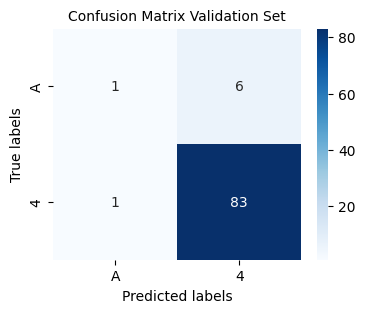


--------------------------------------------------

Test Set


Accuracy: 0.9341
Precision: 0.9762
Recall: 0.9535


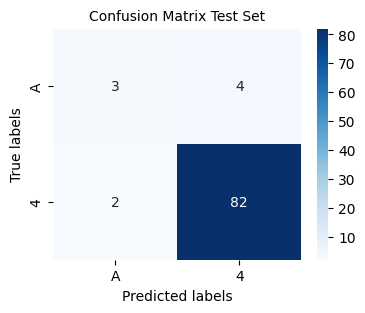

In [19]:
class_labels = ["4","A"]
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, Y_train)

y_validation_pred = logistic_reg.predict(X_validation)
accuracy , precision, recall = metrics(Y_validation, y_validation_pred)
print("Validation Set\n\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
binary_confusion_mx(Y_validation, y_validation_pred, "Validation Set")
print()
print("--------------------------------------------------")
print()
y_test_pred = logistic_reg.predict(X_test)
accuracy , precision, recall = metrics(Y_test, y_test_pred)
print("Test Set\n\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
binary_confusion_mx(Y_test, y_test_pred ,"Test Set")

### Display the ROC curve and the AUC for the validation and test set

In [20]:
print("ROC for validation set\n\n", roc_curve(Y_validation, y_validation_pred))
print("\nROC for test set\n\n",roc_curve(Y_test, y_test_pred))

ROC for validation set

 (array([0.        , 0.85714286, 1.        ]), array([0.        , 0.98809524, 1.        ]), array([2, 1, 0]))

ROC for test set

 (array([0.        , 0.57142857, 1.        ]), array([0.        , 0.97619048, 1.        ]), array([2, 1, 0]))


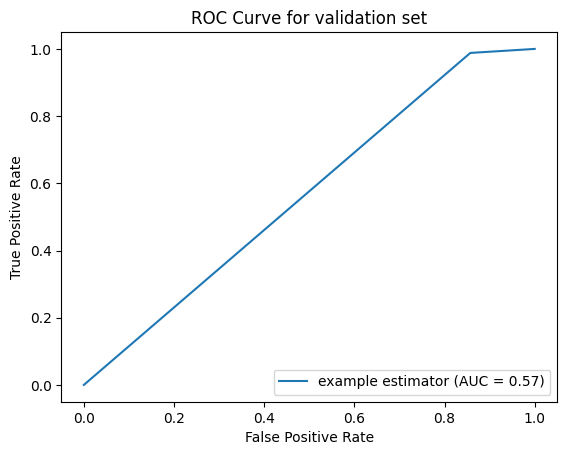

In [21]:
fpr, tpr, thresholds = roc_curve(Y_validation, y_validation_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.title("ROC Curve for validation set")
plt.show()

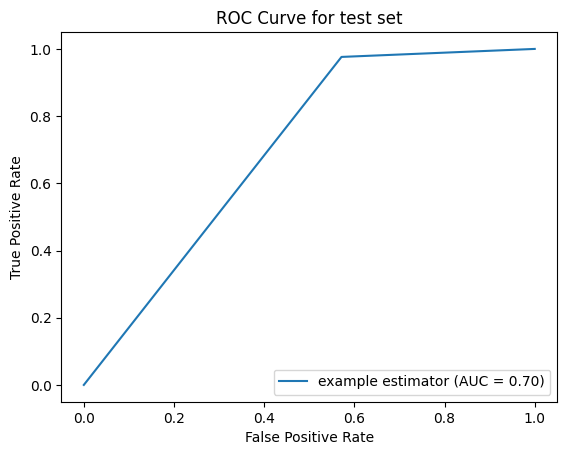

In [22]:
fpr, tpr, thresholds = roc_curve(Y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.title("ROC Curve for test set")
plt.show()

**According to the validation set results :**

* The accuracy of the model reached over 92 percent and that means the model can correctly classify over 92 percent of the images right.
*   The precision of the model reached over 98 percent and that means the model predicts the points as "A" and it is correct over 98 percent of the time which means it has low false positive rate for class "A".
*   The recall of the model reached over 93 percent and that means the model predicts the points of class "A" correct over 93 percent of the time which means it has low false negative rate for class "A".
* For the ROC curve, the area under the curve is 0.57 that means the model has difficulties distinguishing between the classes.




**According to the testing set results :**

* The accuracy of the model reached over 93 percent and that means the model can correctly classify over 93 percent of the images right.
*   The precision of the model reached over 97 percent and that means the model predicts the points as "A" and it is correct over 97 percent of the time which means it has low false positive rate for class "A".
*   The recall of the model reached over 95 percent and that means the model predicts the points of class "A" correct over 95 percent of the time which means it has low false negative rate for class "A".
* For the ROC curve, the area under the curve is 0.70 that means the model doing enough well in distinguishing between the classes.




## **1.3 Multiclass classification**

### Encoding the labels to a numeric form

In [23]:
le = LabelEncoder()
data['Label'] = le.fit_transform(data["Label"])
data

,Image,Label,Image Filename
0,"[[0.6069828920794778, 0.6087645287917142, 0.60...",0,img005-00022.png
1,"[[0.8392273039215685, 0.8392878921568627, 0.83...",0,img005-00019.png
2,"[[0.2300562832635245, 0.2227196269514614, 0.21...",0,img005-00032.png
3,"[[0.25113659695695023, 0.25048025450945155, 0....",0,img005-00002.png
4,"[[0.7131766902759937, 0.7130395433046856, 0.71...",0,img005-00034.png
...,...,...,...
834,"[[0.3111028777056426, 0.3055762374111114, 0.31...",2,img018-00183.png
835,"[[0.7060452627035774, 0.692703164148221, 0.699...",2,img018-00189.png
836,"[[0.4013924086306933, 0.4047186299374385, 0.39...",2,img018-00122.png
837,"[[0.15155651348479954, 0.16337707113899935, 0....",2,img018-00037.png


### Split the data into X and Y

In [24]:
X = data['Image']
Y = data['Label']
X = [img.ravel() for img in X]
X = np.array(X)

### Split the X and Y data into training set with 70 percent of the data & validation and testing set 15 percent of the data each

In [25]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42 , stratify= Y )
X_validation, X_test, Y_validation, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42 , stratify= Y_temp)

print(f"Train set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_validation)} samples")
print(f"Test set size: {len(X_test)} samples")

Train set size: 587 samples
Validation set size: 126 samples
Test set size: 126 samples


### Fit the OVR with logistic regression models over the cut of training set and predict on the validation and test set and display the confusion matrix and the metrics for each class

Validation Set


Accuracy: 0.6905
Class A
Precision score for class : 0.666666667
Recall score for class : 0.2857143
F1 score for class : 0.4

-----------------------
Class 4
Precision score for class : 0.740384615
Recall score for class : 0.9166667
F1 score for class : 0.8

-----------------------
Class U
Precision score for class : 0.421052632
Recall score for class : 0.2758621
F1 score for class : 0.3

-----------------------
Class H
Precision score for class : nan
Recall score for class : 0.0000000
F1 score for class : nan

-----------------------
--------------------------------------------------


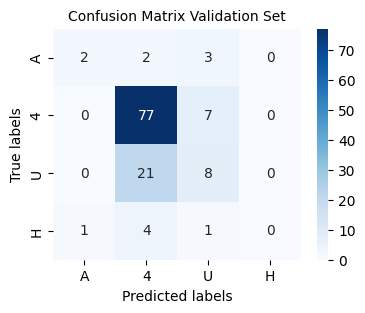

Test Set


Accuracy: 0.7222
Class A
Precision score for class : 0.500000000
Recall score for class : 0.4285714
F1 score for class : 0.5

-----------------------
Class 4
Precision score for class : 0.767676768
Recall score for class : 0.9047619
F1 score for class : 0.8

-----------------------
Class U
Precision score for class : 0.526315789
Recall score for class : 0.3448276
F1 score for class : 0.4

-----------------------
Class H
Precision score for class : 1.000000000
Recall score for class : 0.3333333
F1 score for class : 0.5

-----------------------


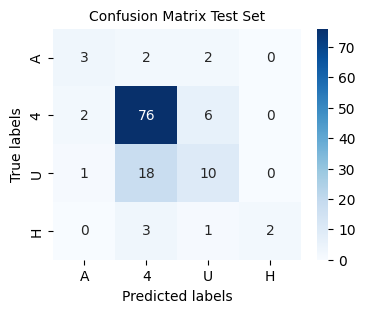

In [26]:
class_labels = ["A", "4", "U", "H"]
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train, Y_train)

y_validation_pred = model.predict(X_validation)
print("Validation Set\n\n")
acc = cm_accuracy(Y_validation, y_validation_pred)
print(f"Accuracy: {acc:.4f}")

validate_dict = {}

for class_label in class_labels:
    validate_dict[class_label] = class_metrics(Y_validation, y_validation_pred, class_label)

for class_label, scores in validate_dict.items():
    precision, recall, f1 = scores
    print(f"Class {class_label}")
    print(f'Precision score for class : {precision:.9f}')
    print(f'Recall score for class : {recall:.7f}')
    print(f'F1 score for class : {f1:.1f}')
    print()
    print("-----------------------")

print("--------------------------------------------------")
confusion_mx(Y_validation, y_validation_pred,class_labels, "Validation Set")

y_test_pred = model.predict(X_test)
print("Test Set\n\n")
acc = cm_accuracy(Y_test, y_test_pred)
print(f"Accuracy: {acc:.4f}")

test_dict = {}
for class_label in class_labels:
    test_dict[class_label] = class_metrics(Y_test, y_test_pred, class_label)

for class_label, scores in test_dict.items():
    precision, recall, f1 = scores
    print(f"Class {class_label}")
    print(f'Precision score for class : {precision:.9f}')
    print(f'Recall score for class : {recall:.7f}')
    print(f'F1 score for class : {f1:.1f}')
    print()
    print("-----------------------")

confusion_mx(Y_test, y_test_pred, class_labels,"Test Set")

### After computing the metrics manually for each class for the validation and test set I display the average metrics for validation and testing sets

In [27]:
data_array = np.array(list(validate_dict.values()))
averages = np.nanmean(data_array, axis=0)
precision, recall, f1 = averages

print("Validation Set\n\n")
print(f'Average precision: {precision:.4f}')
print(f'Average recall: {recall:.4f}')
print(f'Average f1: {f1:.4f}')

Validation Set


Average precision: 0.6094
Average recall: 0.3696
Average f1: 0.5175


In [28]:
data_array = np.array(list(test_dict.values()))
averages = np.nanmean(data_array, axis=0)
precision, recall, f1 = averages

print("Test Set\n\n")
print(f'Average precision: {precision:.4f}')
print(f'Average recall: {recall:.4f}')
print(f'Average f1: {f1:.4f}')

Test Set


Average precision: 0.6985
Average recall: 0.5029
Average f1: 0.5522


## **According to the validation set results :**


*   The overall accuracy of the model reached over 69 percent and that means the model can correctly classify over 69 percent of the images right.

**For class "A":**


*   The precision for this class reached over 66 percent and that means the model predicts the points as "A" and it is correct over 66 percent of the time and the others are false positive.
*  The recall for this class reached over 28 percent and that means the model predicts the points of class "A" correct over 28 percent of the time and the others are false negative.
*  The F1 score for this class reached  40 percent and that means the balance between precision and recall isn't so high so there is a room for improvement.

**For class "4":**


*   The precision for this class reached over 74 percent and that means the model predicts the points as "4" and it is correct over 74 percent of the time and the others are false positive.
*   The recall for this class reached over 91 percent and that means the model predicts the points of class "4" correct over 91 percent of the time and the others are false negative.
*   The F1 score for this class reached  80 percent and that means the balance between precision and recall is high for this class.

**For class "U:**

*   The precision for this class reached over 42 percent and that means the model predicts the points as "U" and it is correct just 42 percent of the time and the others are false positive.
*   The recall for this class reached over 27 percent and that means the model predicts the points of class "U" correct just 27 percent of the time and the others are false negative.
*   The F1 score for this class reached  30 percent and that means the balance between precision and recall is low for this class which suggests that there is suggestions for improvement.

**For class "H":**
*   The precision, recall and f1 score for this class is all zero so the model doing badly according to this class.

### **The over all results for the validation set :**
* The average precision for this set is over 60 percent and that means the model predicts the points correctly over 60 percent of the time.
* The average recall for this set is over 36 percent and that means the model predicts the points of classs in the validation set correctly just 36 percent of the time.
* The f1 score for this set is over 50 percent and that means the model can be improved because of the low balance between precision and recall.

**The model doing very well with class "4" and good with classes "A" and "U" and very bad with class "H".**








## **According to the testing set results :**


*   The overall accuracy of the model reached over 72 percent and that means the model can correctly classify over 72 percent of the images right.

**For class "A":**


*   The precision for this class reached 50 percent and that means the model predicts the points as "A" and it is correct 50 percent of the time and the others are false positive.
*  The recall for this class reached over 42 percent and that means the model predicts the points of class "A" correct over 42 percent of the time and the others are false negative.
*  The F1 score for this class reached  50 percent and that means the balance between precision and recall isn't so high so there is a room for improvement.

**For class "4":**


*   The precision for this class reached over 76 percent and that means the model predicts the points as "4" and it is correct over 76 percent of the time and the others are false positive.
*   The recall for this class reached over 90 percent and that means the model predicts the points of class "4" correct over 90 percent of the time and the others are false negative.
*   The F1 score for this class reached  80 percent and that means the balance between precision and recall is high for this class.

**For class "U:**

*   The precision for this class reached over 52 percent and that means the model predicts the points as "U" and it is correct just 52 percent of the time and the others are false positive.
*   The recall for this class reached over 34 percent and that means the model predicts the points of class "U" correct just 34 percent of the time and the others are false negative.
*   The F1 score for this class reached  40 percent and that means the balance between precision and recall is low for this class which indicates that there is suggestions for improvement.

**For class "H":**
*   The precision for this class reached 100 percent which means the model predicts the points as "H" and it is correct 100 percent of the time and the are no false positive.
*    The recall for this class reached over 33 percent and that means the model predicts the points of class "H" correct just 33 percent of the time and the others are false negative.
*    The F1 score for this class reached  50 percent and that means the balance between precision and recall is not high for this class which indicates that there is suggestions for improvement.

### **The over all results for the testing set :**
* The average precision for this set is over 69 percent and that means the model predicts the points correctly over 69 percent of the time.
* The average recall for this set is over 50 percent and that means the model predicts the points of classs in the validation set correctly just 50 percent of the time.
* The f1 score for this set is over 55 percent and that means the model can be improved because of the low balance between precision and recall.

**The model doing very well with class "4" and class "H" and good with classes "A" and "U".**






